# How Fair are Roll20.net's dice rolls?

Friends of mine play dnd regularly on [roll20.net](https://roll20.net/) (certainly not me, I would never do something so geeky).  Anyway, I, I mean, my friends often complain that they get unexpected runs of high or low numbers that never seem to occur in real life.   Of course, I think there are some well known cognitive biases that seem relevant, such as [The Gambler's Fallacy](https://en.wikipedia.org/wiki/Gambler%27s_fallacy).

So is the site fair? I don't know, but this is a perfect chance to call upon our decadant civilization's latest fetish: *science*.

## Testing my methodology with python's random number generator.

Okay, so first we need to bring in a bunch of tools made by people who are probably much closer to real scientists than me.  We'll be leaning heavily on the work of other people.  This is normal in science, I'm told, but theoretically I should verify that the tools I'm using are accurate.

In [1]:
import random
import math

import statistics
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline

First, let's declare some functions to help test with python's RNG (random number generator).

In [2]:
def roll_n_sided_die(sides):
    return random.randint(1, sides)


def get_rolls(sides, repetitions):
    rolls = []
    for _ in range(repetitions):
        rolls.append(roll_n_sided_die(sides))
    return rolls


def make_test_rolls(sides, reps):
    return get_rolls(sides, reps)

We will be using this histogram a lot (in both the python RNG tests and for the results I get from roll20.net), so let's go ahead and abstract it into a function.

In [3]:
def plot_rolls(roll_list, sides, obs):    
    counts = [roll_list.count(i) for i in set(roll_list)]
    
    ideal_line = ((1/sides) * obs)
    
    xticks = [x for x in set(roll_list)]
    # ci = sms.DescrStatsW(xticks).tconfint_mean()
    # y_r = [i - sms.DescrStatsW(range(i)).tconfint_mean()[1] for i in xticks]
        
    plt.bar(xticks, height=counts, color="blue", width=.75)
    plt.xticks(xticks)
        
    plt.axhline(ideal_line, color="orange", dashes=(4,2,1,2)) # pardon my magic numbers
    plt.xlabel('Sides')
    plt.ylabel('Observations')

Using the built in random module in python we'll pretend to roll a 20 sided die 20 times

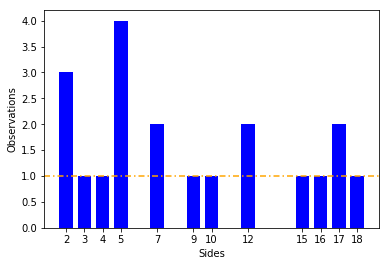

In [4]:
sides = 20
obs = 20
rolls = make_test_rolls(sides, obs)
plot_rolls(rolls, sides, obs)

Of course, a small sample gives expectedly spotty results. Some sides never get rolled at all!  The orange dotted line indicates how many times we would ideally expect each side to appear (1 of the 20 sides for each of 20 rolls).

### So how many rolls do we need?

Well, I'm not clever enough to come up with this math all on by my lonesome self.  I referred heavily on a number of internet searches, and these three results are the basis of most of "my" "work":

- [timothyweber.org](https://timothyweber.org/node/254), [this too](https://timothyweber.org/node/255)
- [twoardsdatascience.com](https://towardsdatascience.com/running-chi-square-tests-in-python-with-die-roll-data-b9903817c51b)
- [rpg.stackexchange.com](https://rpg.stackexchange.com/questions/70802/how-can-i-test-whether-a-die-is-fair)

rpg.stackexchange.com says you need at least five times as many rolls as there are sides on the die.  So 100 for a d20. 

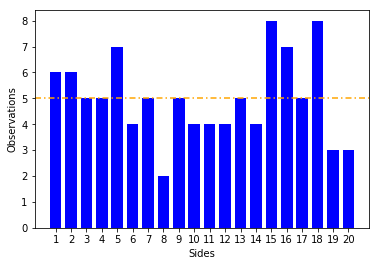

In [5]:
sides = 20
obs = 100
rolls = make_test_rolls(sides, obs)
plot_rolls(rolls, sides, obs)

But the results look all over the place.

However, rpg.stackexchange.com was the odd man out and used a different methodology than my other two references, which preferred the chi-squared test. I expect the answer from rpg.stackexchange.com is meant to be the bare minimum for rolling dice manually, which takes a long time, even for 100 observations.  We do see here, however, that every side occurs at least twice in a 100 rolls, with a whopping 11 results of 19.

Let's try another test.

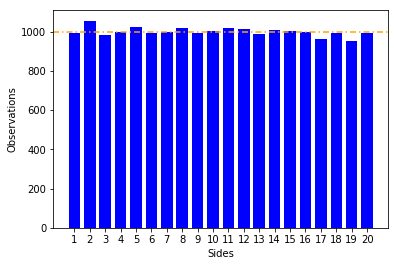

In [6]:
obs = 20000
rolls = make_test_rolls(sides, obs)
plot_rolls(rolls, sides, obs)

At 20000 rolls (which should favor 1000 observed results per side, c.f. the 1000 per 6 sides as done at [timothyweber.org](https://timothyweber.org/node/254)) you see the distribution is not flat completely flat, but it looks a hell of a lot more regular.  As I understand it, this is generally true of randomness.  The larger the number of observations, the more regular they should become.  So things are looking pretty good so far for python's RNG.

## Testing roll20.net's roll function for fairness

So getting the rolls from roll20 was the first challenge.  You can roll a number of n-sided die in one command, and copy and paste the response from the chat window, which tends to format each number, +, and ( or ) symbol on its own line.  No problem.  a computer can sort of the junk easily enough.

In [7]:
def read_roll20_rolls(filename):
    with open(filename, 'r') as f:
        rolls = f.readlines()
    rolls = [line.strip() for line in rolls]
    rolls = [line for line in rolls if line not in '()+']
    rolls = [float(line) for line in rolls]
    return rolls

Though my second road bump was realizing that roll20 silently limits the number of dice you can roll in a single command (I'm guessing to stop people from spamming chat).  On copying and pasting the results of the command `/roll 20000d20` I found that I received slightly less than a 1000 integers.  Rolling `1000d20` returned also slightly less than 1000.  

So my solution was to manually roll in batches of 500 and manually copy the results into a single text file.  A bit tedious and error prone, so keep in mind that though I tried to be careful, I could have slipped up on any one or more copy operations.  

**This is not a rigorous science shop.  This is a barely holding it together mad science shop of a caffeinated nerd with not enough patience for real science.**

20000 observations


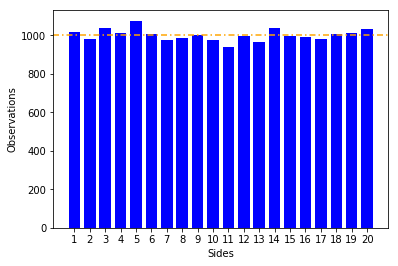

In [22]:
sides=20
rolls = read_roll20_rolls('data/rolls3.txt')
obs = len(rolls)
print("{} observations".format(obs))
plot_rolls(rolls, sides, obs)

In [9]:
sms.DescrStatsW([30, 100, 60, 80]).tconfint_mean()

(19.98482260012711, 115.0151773998729)

In [10]:
30 - 19.98482260012711

10.01517739987289

In [11]:
obs = [600, 470, 170, 430, 300]
n = len(obs)
m = statistics.mean(obs)
std_d = np.std(obs)
z = 2.807

In [12]:
sms.DescrStatsW(obs).tconfint_mean()

(189.48320139232717, 598.5167986076729)

578.9384872307546

In [14]:
m = 175
z = 1.960
std_d = 20
n = 40
m + z * (std_d/math.sqrt(n))

181.19806421393002

In [15]:
sms.DescrStatsW(rolls).tconfint_mean()

(10.444456199307691, 10.67234380069231)